# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Initialization

In [1]:
import pandas as pd

import numpy as np

import matplotlib as plot

import seaborn as sns

from scipy import stats as st

from functools import reduce

import matplotlib.pyplot as plt

from scipy.stats import shapiro

%matplotlib inline


## Load data

In [2]:
call = pd.read_csv('/datasets/megaline_calls.csv')
wifi = pd.read_csv('/datasets/megaline_internet.csv')
msg = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
user = pd.read_csv('/datasets/megaline_users.csv')

## Prepare the data

## Plans

In [3]:
print(plans.shape)
print(plans.info())
print(plans.describe())

(2, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None
       messages_included  mb_per_month_included  minutes_included  \
count           2.000000               2.000000          2.000000   
mean          525.000000           23040.000000       1750.000000   
std           671.751442           10861.160159       1767.766953   
min            50.000000 

In [4]:
# Print a sample of data for plans
plans = plans.set_index('plan_name')
(display(plans.head(5)))



,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
plan_name,,,,,,,
surf,50,15360,500,20,10,0.03,0.03
ultimate,1000,30720,3000,70,7,0.01,0.01


The data in this dataframe all looks to be correct.

## Users

In [5]:
print(user.shape)
print(user.info())
print(user.describe())

(500, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
           user_id         age
count   500.000000  500.000000
mean   1249.500000   45.486000
std     144.481833   16.972269
min    1000.000000   18.000000
25%    1124.750000   30.000000
50%    1249.500000   46.000000
75%    1374.250000   61.000000
max    1499.000000   75.000000


In [6]:
print(display(user.head(5)))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


None


Issues that can be fixed in this dataframe would be the reg_date and churn_date column turned into Datetime rather than object. Also there are 466 missing values from the Churn Date column. We will have to see if we can fill in the column where it would make sense, but most likely we will fill with NaNs as it is missing almost 90% of its values.

### Fix Data

In [7]:
user['reg_date'] = pd.to_datetime(user['reg_date'], format='%Y-%m-%d')
user['churn_date'] = pd.to_datetime(user['churn_date'], format='%Y-%m-%d')

user.info()
user['churn_date'].unique()
display(user)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaT
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaT
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaT
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaT


### Enrich Data

In [8]:
user['month'] = user['reg_date'].dt.strftime('%m/%Y')

user.info()
display(user)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
 8   month       500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 35.3+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,12/2018
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,08/2018
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,10/2018
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,01/2018
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,05/2018
...,...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaT,09/2018
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaT,02/2018
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaT,12/2018
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaT,02/2018


## Calls

In [9]:
call['duration'] = np.ceil(call['duration'])
call = call.astype({"duration":'int'})

print(call.shape)
print(call.info())
print(call.describe())

(137735, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         137735 non-null  object
 1   user_id    137735 non-null  int64 
 2   call_date  137735 non-null  object
 3   duration   137735 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.2+ MB
None
             user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       7.146673
std       139.416268       5.953919
min      1000.000000       0.000000
25%      1128.000000       2.000000
50%      1247.000000       6.000000
75%      1365.000000      11.000000
max      1499.000000      38.000000


In [10]:
print(display(call.head(5)))
call.info()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,15
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,5


None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         137735 non-null  object
 1   user_id    137735 non-null  int64 
 2   call_date  137735 non-null  object
 3   duration   137735 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.2+ MB


The main issue in this dataframe would be converting the call_date column to datetime as it is a date. We would also convert the id column into an int.

### Fix data

In [11]:
call = call.astype({"id": int})
call['call_date'] = pd.to_datetime(call['call_date'], format='%Y-%m-%d')

call.info()
display(call)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  int64         
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 4.2 MB


,id,user_id,call_date,duration
0,100093,1000,2018-12-27,9
1,1000145,1000,2018-12-27,14
2,1000247,1000,2018-12-27,15
3,1000309,1000,2018-12-28,6
4,1000380,1000,2018-12-30,5
...,...,...,...,...
137730,1499199,1499,2018-11-21,9
137731,1499200,1499,2018-10-20,11
137732,1499201,1499,2018-09-21,9
137733,1499202,1499,2018-10-10,1


### Enrich data

In [12]:
call['month'] = call['call_date'].dt.strftime('%m/%Y')

display(call)

,id,user_id,call_date,duration,month
0,100093,1000,2018-12-27,9,12/2018
1,1000145,1000,2018-12-27,14,12/2018
2,1000247,1000,2018-12-27,15,12/2018
3,1000309,1000,2018-12-28,6,12/2018
4,1000380,1000,2018-12-30,5,12/2018
...,...,...,...,...,...
137730,1499199,1499,2018-11-21,9,11/2018
137731,1499200,1499,2018-10-20,11,10/2018
137732,1499201,1499,2018-09-21,9,09/2018
137733,1499202,1499,2018-10-10,1,10/2018


## Messages

In [13]:
print(msg.shape)
print(msg.info())
print(msg.describe())

(76051, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None
            user_id
count  76051.000000
mean    1245.972768
std      139.843635
min     1000.000000
25%     1123.000000
50%     1251.000000
75%     1362.000000
max     1497.000000


In [14]:
print(display(msg.head(5)))

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


None


The issues in this data are that the id column should be int and the message_date column should be datetime.

### Fix data

In [15]:
msg = msg.astype({"id": int})
msg['message_date'] = pd.to_datetime(msg['message_date'], format='%Y-%m-%d')
msg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  int64         
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.7 MB


### Enrich data

In [16]:
msg['month'] = msg['message_date'].dt.strftime('%m/%Y')
display(msg)

,id,user_id,message_date,month
0,1000125,1000,2018-12-27,12/2018
1,1000160,1000,2018-12-31,12/2018
2,1000223,1000,2018-12-31,12/2018
3,1000251,1000,2018-12-27,12/2018
4,1000255,1000,2018-12-26,12/2018
...,...,...,...,...
76046,1497526,1497,2018-12-24,12/2018
76047,1497536,1497,2018-12-24,12/2018
76048,1497547,1497,2018-12-31,12/2018
76049,1497558,1497,2018-12-24,12/2018


## Internet

In [17]:
print(wifi.shape)
print(wifi.info())
print(wifi.describe())

(104825, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None
             user_id        mb_used
count  104825.000000  104825.000000
mean     1242.496361     366.713701
std       142.053913     277.170542
min      1000.000000       0.000000
25%      1122.000000     136.080000
50%      1236.000000     343.980000
75%      1367.000000     554.610000
max      1499.000000    1693.470000


In [18]:
print(display(wifi.head(5)))

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


None


Most of the data in this dataframe is correct however there are some corrections that we can make. It would be best to turn the id column into int and the session_date column into datetime.

### Fix data

In [19]:
wifi = wifi.astype({"id": int})
wifi['session_date'] = pd.to_datetime(wifi['session_date'], format='%Y-%m-%d')
wifi.info()
display(wifi)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  int64         
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.2 MB


,id,user_id,session_date,mb_used
0,100013,1000,2018-12-29,89.86
1,1000204,1000,2018-12-31,0.00
2,1000379,1000,2018-12-28,660.40
3,1000413,1000,2018-12-26,270.99
4,1000442,1000,2018-12-27,880.22
...,...,...,...,...
104820,1499215,1499,2018-10-20,218.06
104821,1499216,1499,2018-12-30,304.72
104822,1499217,1499,2018-09-22,292.75
104823,1499218,1499,2018-12-07,0.00


### Enrich data

In [20]:
wifi['month'] = wifi['session_date'].dt.strftime('%m/%Y')
display(wifi)

,id,user_id,session_date,mb_used,month
0,100013,1000,2018-12-29,89.86,12/2018
1,1000204,1000,2018-12-31,0.00,12/2018
2,1000379,1000,2018-12-28,660.40,12/2018
3,1000413,1000,2018-12-26,270.99,12/2018
4,1000442,1000,2018-12-27,880.22,12/2018
...,...,...,...,...,...
104820,1499215,1499,2018-10-20,218.06,10/2018
104821,1499216,1499,2018-12-30,304.72,12/2018
104822,1499217,1499,2018-09-22,292.75,09/2018
104823,1499218,1499,2018-12-07,0.00,12/2018


## Study plan conditions

In [21]:
print(plans.shape)
print(plans.info())
display(plans)

(2, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, surf to ultimate
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
dtypes: float64(2), int64(5)
memory usage: 128.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
plan_name,,,,,,,
surf,50,15360,500,20,10,0.03,0.03
ultimate,1000,30720,3000,70,7,0.01,0.01


## Aggregate data per user



In [22]:
call_per_month = call.pivot_table(index=['user_id', 'month'])
print(call_per_month)

                 duration            id
user_id month                          
1000    12/2018  7.750000  9.442654e+05
1001    08/2018  6.740741  9.345431e+05
        09/2018  6.428571  8.339501e+05
        10/2018  6.046154  8.182951e+05
        11/2018  6.656250  8.013700e+05
...                   ...           ...
1498    12/2018  8.692308  9.727455e+05
1499    09/2018  8.439024  1.035156e+06
        10/2018  7.264151  7.787315e+05
        11/2018  6.844444  7.376020e+05
        12/2018  7.630769  8.100211e+05

[2258 rows x 2 columns]


In [23]:
minutes_per_month = call.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum'])
print(minutes_per_month)

                     sum
                duration
user_id month           
1000    12/2018      124
1001    08/2018      182
        09/2018      315
        10/2018      393
        11/2018      426
...                  ...
1498    12/2018      339
1499    09/2018      346
        10/2018      385
        11/2018      308
        12/2018      496

[2258 rows x 1 columns]


In [24]:
messages_per_month = msg.groupby(by=['user_id','month']).size().reset_index()
print(messages_per_month)

      user_id    month   0
0        1000  12/2018  11
1        1001  08/2018  30
2        1001  09/2018  44
3        1001  10/2018  53
4        1001  11/2018  36
...       ...      ...  ..
1801     1496  09/2018  21
1802     1496  10/2018  18
1803     1496  11/2018  13
1804     1496  12/2018  11
1805     1497  12/2018  50

[1806 rows x 3 columns]


In [25]:
volume_per_month = wifi.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc=['sum'])
volume_per_month

sum
                  mb_used
user_id month            
1000    12/2018   1901.47
1001    08/2018   6919.15
        09/2018  13314.82
        10/2018  22330.49
        11/2018  18504.30
...                   ...
1498    12/2018  23137.69
1499    09/2018  12984.76
        10/2018  19492.43
        11/2018  16813.83
        12/2018  22059.21

[2277 rows x 1 columns]

In [26]:
def round_to_gb(value):
    return np.ceil(value/1024)
volume_per_month[('sum', 'mb_used')] = volume_per_month[('sum', 'mb_used')].apply(round_to_gb)
volume_per_month

sum
                mb_used
user_id month          
1000    12/2018     2.0
1001    08/2018     7.0
        09/2018    14.0
        10/2018    22.0
        11/2018    19.0
...                 ...
1498    12/2018    23.0
1499    09/2018    13.0
        10/2018    20.0
        11/2018    17.0
        12/2018    22.0

[2277 rows x 1 columns]

In [27]:
user_plan = user.pivot_table(index=['user_id', 'plan','month'])
print(user_plan)
display(user_plan)

                          age
user_id plan     month       
1000    ultimate 12/2018   45
1001    surf     08/2018   28
1002    surf     10/2018   36
1003    surf     01/2018   52
1004    surf     05/2018   40
...                       ...
1495    surf     09/2018   67
1496    surf     02/2018   49
1497    ultimate 12/2018   49
1498    surf     02/2018   51
1499    surf     05/2018   37

[500 rows x 1 columns]


,,,age
user_id,plan,month,
1000,ultimate,12/2018,45
1001,surf,08/2018,28
1002,surf,10/2018,36
1003,surf,01/2018,52
1004,surf,05/2018,40
...,...,...,...
1495,surf,09/2018,67
1496,surf,02/2018,49
1497,ultimate,12/2018,49


In [28]:
call_data = call_per_month.merge(minutes_per_month, on=['user_id', 'month'], how='outer')

call_data = call_data.merge(messages_per_month, on=['user_id', 'month'], how='outer')

call_data = call_data.merge(volume_per_month, on=['user_id', 'month'], how='outer')

call_data = call_data.merge(user_plan, on=['user_id', 'month'], how='outer')

print(call_data)

display(call_data)

      user_id    month  duration             id  (sum, duration)     0  \
0        1000  12/2018  7.750000  944265.375000            124.0  11.0   
1        1001  08/2018  6.740741  934543.074074            182.0  30.0   
2        1001  09/2018  6.428571  833950.081633            315.0  44.0   
3        1001  10/2018  6.046154  818295.107692            393.0  53.0   
4        1001  11/2018  6.656250  801370.000000            426.0  36.0   
...       ...      ...       ...            ...              ...   ...   
2541     1492  03/2018       NaN            NaN              NaN   NaN   
2542     1493  03/2018       NaN            NaN              NaN   NaN   
2543     1494  04/2018       NaN            NaN              NaN   NaN   
2544     1496  02/2018       NaN            NaN              NaN   NaN   
2545     1499  05/2018       NaN            NaN              NaN   NaN   

      (sum, mb_used)   age  
0                2.0  45.0  
1                7.0  28.0  
2               14.0   N

/opt/conda/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,user_id,month,duration,id,"(sum, duration)",0,"(sum, mb_used)",age
0,1000,12/2018,7.750000,944265.375000,124.0,11.0,2.0,45.0
1,1001,08/2018,6.740741,934543.074074,182.0,30.0,7.0,28.0
2,1001,09/2018,6.428571,833950.081633,315.0,44.0,14.0,NaN
3,1001,10/2018,6.046154,818295.107692,393.0,53.0,22.0,NaN
4,1001,11/2018,6.656250,801370.000000,426.0,36.0,19.0,NaN
...,...,...,...,...,...,...,...,...
2541,1492,03/2018,NaN,NaN,NaN,NaN,NaN,63.0
2542,1493,03/2018,NaN,NaN,NaN,NaN,NaN,18.0
2543,1494,04/2018,NaN,NaN,NaN,NaN,NaN,70.0
2544,1496,02/2018,NaN,NaN,NaN,NaN,NaN,49.0


In [29]:
user

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,12/2018
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,08/2018
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,10/2018
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,01/2018
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,05/2018
...,...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaT,09/2018
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaT,02/2018
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaT,12/2018
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaT,02/2018


In [30]:
call_data = call_data.reset_index().merge(user, left_on='user_id', right_on='user_id')

In [31]:
display(call_data)

,index,user_id,month_x,duration,id,"(sum, duration)",0,"(sum, mb_used)",age_x,first_name,last_name,age_y,city,reg_date,plan,churn_date,month_y
0,0,1000,12/2018,7.750000,944265.375000,124.0,11.0,2.0,45.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,12/2018
1,1,1001,08/2018,6.740741,934543.074074,182.0,30.0,7.0,28.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,08/2018
2,2,1001,09/2018,6.428571,833950.081633,315.0,44.0,14.0,NaN,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,08/2018
3,3,1001,10/2018,6.046154,818295.107692,393.0,53.0,22.0,NaN,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,08/2018
4,4,1001,11/2018,6.656250,801370.000000,426.0,36.0,19.0,NaN,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,08/2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,2441,1307,12/2018,NaN,NaN,NaN,NaN,NaN,28.0,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,NaT,12/2018
2542,2447,1319,06/2018,NaN,NaN,NaN,NaN,NaN,21.0,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,NaT,06/2018
2543,2479,1378,12/2018,NaN,NaN,NaN,NaN,NaN,22.0,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",2018-12-17,surf,NaT,12/2018
2544,2527,1463,11/2018,NaN,NaN,NaN,NaN,NaN,30.0,Dinorah,Simmons,30,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-11-27,ultimate,NaT,11/2018


In [32]:
call_data.fillna(0, inplace=True)
display(call_data.head())

,index,user_id,month_x,duration,id,"(sum, duration)",0,"(sum, mb_used)",age_x,first_name,last_name,age_y,city,reg_date,plan,churn_date,month_y
0,0,1000,12/2018,7.750000,944265.375000,124.0,11.0,2.0,45.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,0,12/2018
1,1,1001,08/2018,6.740741,934543.074074,182.0,30.0,7.0,28.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,0,08/2018
2,2,1001,09/2018,6.428571,833950.081633,315.0,44.0,14.0,0.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,0,08/2018
3,3,1001,10/2018,6.046154,818295.107692,393.0,53.0,22.0,0.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,0,08/2018
4,4,1001,11/2018,6.656250,801370.000000,426.0,36.0,19.0,0.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,0,08/2018


In [33]:
call_data = call_data.rename(columns={('duration'):"number of calls",('sum', 'duration'): "amount of minutes",('sum', 'mb_used'): "gb used",('id_y'):'messages sent'})


In [34]:
display(call_data)

,index,user_id,month_x,number of calls,id,amount of minutes,0,gb used,age_x,first_name,last_name,age_y,city,reg_date,plan,churn_date,month_y
0,0,1000,12/2018,7.750000,944265.375000,124.0,11.0,2.0,45.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,0,12/2018
1,1,1001,08/2018,6.740741,934543.074074,182.0,30.0,7.0,28.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,0,08/2018
2,2,1001,09/2018,6.428571,833950.081633,315.0,44.0,14.0,0.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,0,08/2018
3,3,1001,10/2018,6.046154,818295.107692,393.0,53.0,22.0,0.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,0,08/2018
4,4,1001,11/2018,6.656250,801370.000000,426.0,36.0,19.0,0.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,0,08/2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,2441,1307,12/2018,0.000000,0.000000,0.0,0.0,0.0,28.0,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,0,12/2018
2542,2447,1319,06/2018,0.000000,0.000000,0.0,0.0,0.0,21.0,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,0,06/2018
2543,2479,1378,12/2018,0.000000,0.000000,0.0,0.0,0.0,22.0,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",2018-12-17,surf,0,12/2018
2544,2527,1463,11/2018,0.000000,0.000000,0.0,0.0,0.0,30.0,Dinorah,Simmons,30,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-11-27,ultimate,0,11/2018


In [35]:
call_data = call_data.drop(columns=['id','reg_date','churn_date','month_y','age_x','first_name','last_name'])


In [36]:
call_data = call_data.rename(columns={'month_x': "month",'user_id': "user id",'first_name': "first name", 'last_name':"last name", 'age_y':"age", 0:"messages sent"})


In [37]:
call_data = call_data.drop_duplicates(keep = 'first')


In [38]:
def get_revenue(call_data):
    
    plan = call_data['plan']
    minutes_used = call_data['amount of minutes']
    number_of_messages = call_data['messages sent']
    gb_used = call_data['gb used']
    
    revenue = plans.loc[plan,'usd_monthly_pay']
    
    if minutes_used > plans.loc[plan,'minutes_included']:
        revenue += (minutes_used - plans.loc[plan,'minutes_included']) * plans.loc[plan,'usd_per_minute']
    if number_of_messages > plans.loc[plan,'messages_included']:
        revenue += (number_of_messages - plans.loc[plan, 'messages_included']) * plans.loc[plan, 'usd_per_message']
    if gb_used > plans.loc[plan,'mb_per_month_included']:
        revenue += (gb_used - plans.loc[plan,'mb_per_month_included']) * plans.loc[plan,'usd_per_gb']
        
    return revenue

call_data['revenue'] = call_data.apply(get_revenue, axis=1)


## Study user behaviour

In [39]:
display(call_data)

,index,user id,month,number of calls,amount of minutes,messages sent,gb used,age,city,plan,revenue
0,0,1000,12/2018,7.750000,124.0,11.0,2.0,45,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,70.00
1,1,1001,08/2018,6.740741,182.0,30.0,7.0,28,"Seattle-Tacoma-Bellevue, WA MSA",surf,20.00
2,2,1001,09/2018,6.428571,315.0,44.0,14.0,28,"Seattle-Tacoma-Bellevue, WA MSA",surf,20.00
3,3,1001,10/2018,6.046154,393.0,53.0,22.0,28,"Seattle-Tacoma-Bellevue, WA MSA",surf,20.09
4,4,1001,11/2018,6.656250,426.0,36.0,19.0,28,"Seattle-Tacoma-Bellevue, WA MSA",surf,20.00
...,...,...,...,...,...,...,...,...,...,...,...
2541,2441,1307,12/2018,0.000000,0.0,0.0,0.0,28,"Boston-Cambridge-Newton, MA-NH MSA",surf,20.00
2542,2447,1319,06/2018,0.000000,0.0,0.0,0.0,21,"Colorado Springs, CO MSA",surf,20.00
2543,2479,1378,12/2018,0.000000,0.0,0.0,0.0,22,"Denver-Aurora-Lakewood, CO MSA",surf,20.00
2544,2527,1463,11/2018,0.000000,0.0,0.0,0.0,30,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,70.00


In [40]:
call_data2 = call_data.copy()
call_data2 = call_data2.drop(columns=['city','month'])

### Calls

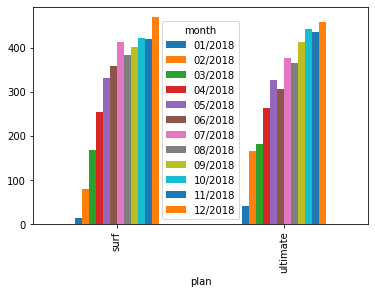

In [41]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.
#ax = call_data.plot.bar(x='amount of minutes', y='user id', rot=0)

#ax = sns.barplot(x="amount of minutes", y="plan", data=call_data)

y = call_data.pivot_table(index='plan',columns='month',values='amount of minutes' ).plot(kind='bar')


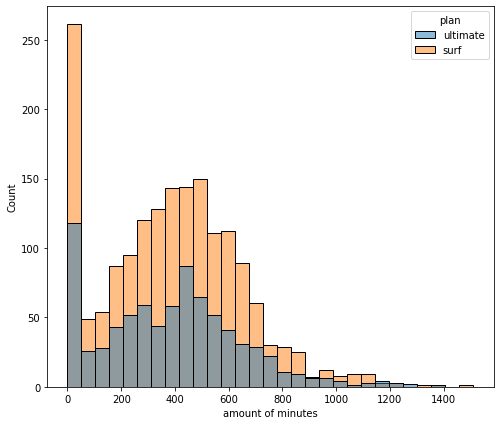

In [42]:
# Compare tcall_data.hist(columns=['amount of minutes'],by=['month'], figsize=(10,10))he number of minutes users of each plan require each month. Plot a histogram.
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.histplot(call_data, x="amount of minutes", hue="plan")

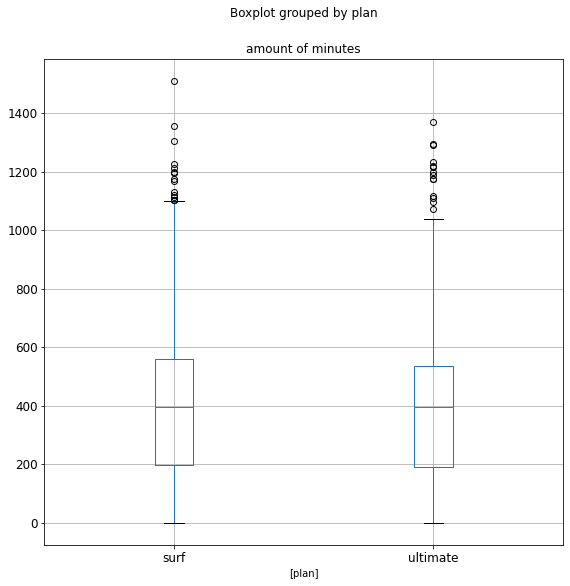

In [43]:
call_data['amount of minutes'].describe()
diff = call_data.boxplot(column=['amount of minutes'], by=['plan'],fontsize=12, figsize=(9,9))

Calling behavior between the surf and ultimate plans are not too far off. There is essentially the same boxplot for the two plans. The median,min,max and iqr's are the same or very similar. This shows that the behavior between the two plans are close in nature

### Messages

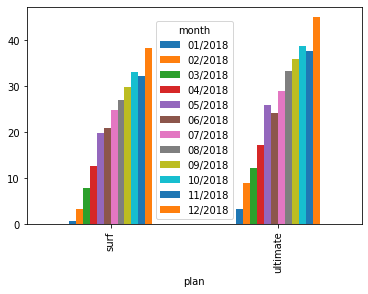

In [44]:
# Compare the number of messages users of each plan tend to send each month

y = call_data.pivot_table(index='plan',columns='month',values='messages sent' ).plot(kind='bar')


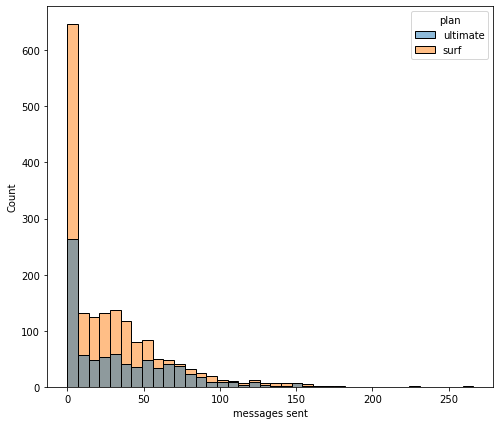

In [45]:
# Compare the amount of internet traffic consumed by users per plan

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.histplot(call_data, x="messages sent", hue="plan")

count    2546.000000
mean       29.870778
std        33.821074
min         0.000000
25%         0.000000
50%        21.000000
75%        48.000000
max       266.000000
Name: messages sent, dtype: float64


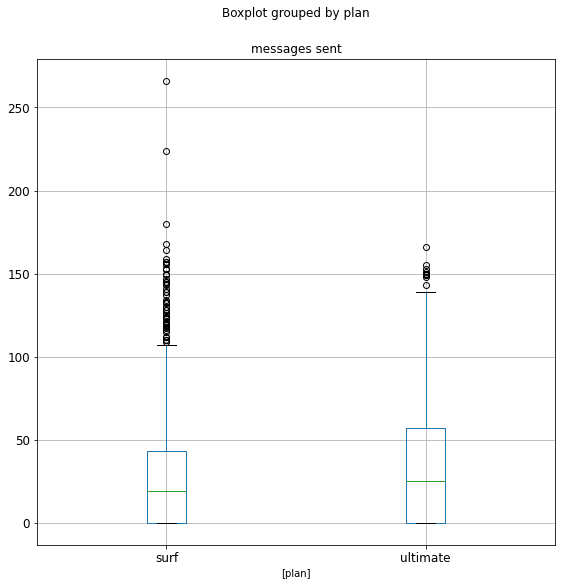

In [46]:
print(call_data['messages sent'].describe())
diff = call_data.boxplot(column=['messages sent'], by=['plan'],fontsize=12, figsize=(9,9))

Behvaior is definetily different in terms of messaging between the surf and ultimate plans. The median is slightly lower for the surf plan and the max is a little bit higher for the ultimate. All together , there seemed to be vastly more particpants of the surf plan but they seemed to send less messages as compared to lower volume but higher message counts for the ultimate plan.

### Internet

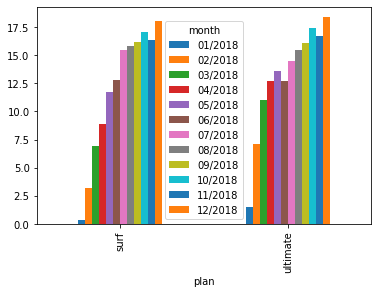

In [47]:
#call_data.groupby(['month'])['amount of minutes'].agg(['sum']).reset_index().sort_values(by='sum', ascending=False).plot(x='month', y='sum',kind='bar')
#call_data.groupby('gb used').count().plot.bar()

y = call_data.pivot_table(index='plan',columns='month',values='gb used' ).plot(kind='bar')


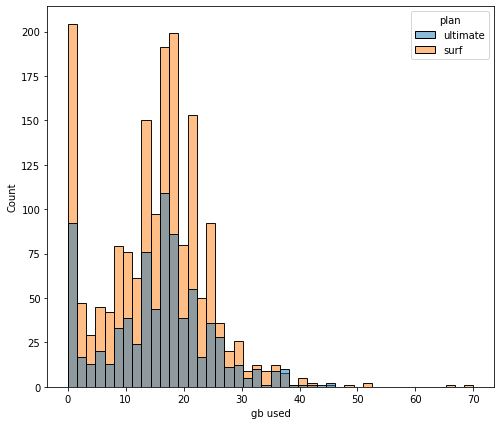

In [48]:
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.histplot(call_data, x="gb used", hue="plan")

count    2546.000000
mean       15.194030
std         8.956567
min         0.000000
25%        10.000000
50%        16.000000
75%        21.000000
max        70.000000
Name: gb used, dtype: float64


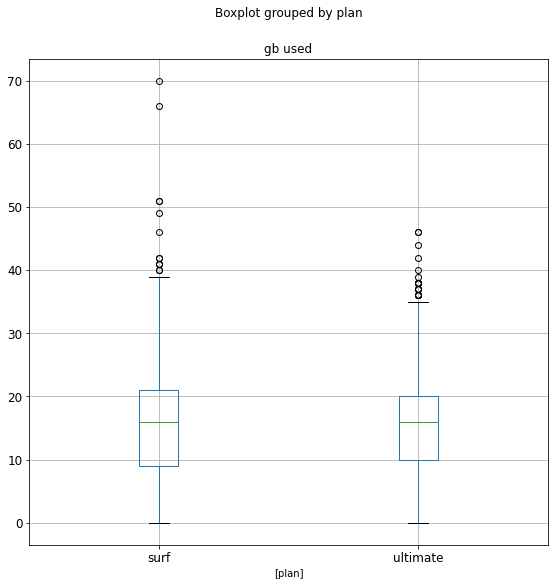

In [49]:
print(call_data['gb used'].describe())
diff = call_data.boxplot(column=['gb used'], by=['plan'],fontsize=12, figsize=(9,9))

Behavior is slightly different between the two phone plans. The minimums and medians are equal but surf's max slightly edges out the ultimate plan. It seems as if participants of the surf plan use more gb's and at a higher volume than ultimate plan holders.

## Revenue

[Likewise you have studied the user behaviour, statistically describe the revenue between the plans.]

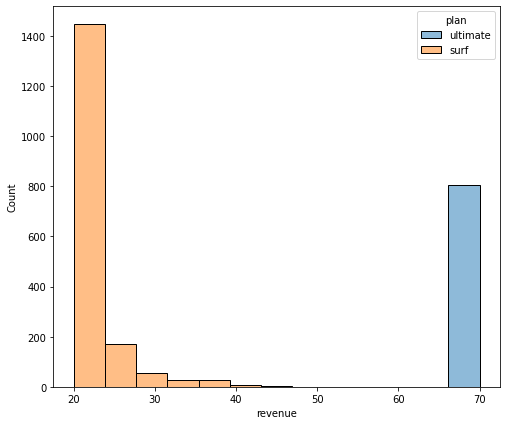

In [50]:
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.histplot(call_data, x="revenue", hue="plan")

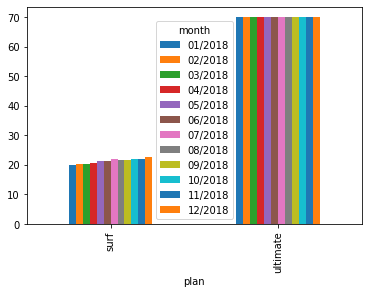

In [51]:
y = call_data.pivot_table(index='plan',columns='month',values='revenue' ).plot(kind='bar')


count    2546.000000
mean       37.078233
std        22.610965
min        20.000000
25%        20.000000
50%        21.770000
75%        70.000000
max        70.000000
Name: revenue, dtype: float64


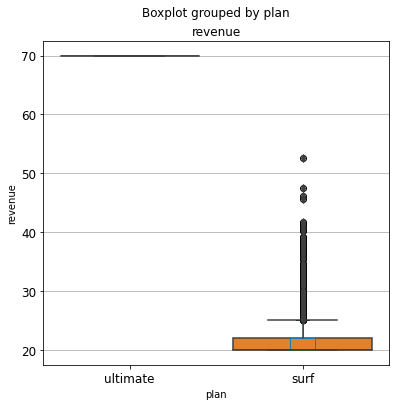

In [52]:
print(call_data['revenue'].describe())

dihff = call_data.boxplot(column=['revenue'], by=['plan'], fontsize=12, figsize=(6,6))

t = sns.boxplot(x= "plan", y="revenue", data=call_data)


The revenue differs drastically between the two plans. Revenue for the ultimate plan sits right at 70 usd whilsts the median for the surf plan is 20 usd but goes out into the range of the mid 50's. The revnue is substantially higher for the surf team.

In [53]:
from scipy import stats as st

prob = 0.68    

lower_limit = (1 - prob) / 2
upper_limit = 1 - (1 - prob) / 2

cols = call_data2.columns[3:-2]

for col in cols:
    mean = call_data2[col].mean()
    std = call_data2[col].std()
    
    distr = st.norm(mean, std)

    lower_range = distr.ppf(lower_limit)
    upper_range = distr.ppf(upper_limit)
    
    print(f'About {prob:.0%} of the values in the «{col}» column will fall between {round(lower_range):5} and {round(upper_range)}.')
    


About 68% of the values in the «amount of minutes» column will fall between   130 and 644.
About 68% of the values in the «messages sent» column will fall between    -4 and 64.
About 68% of the values in the «gb used» column will fall between     6 and 24.
About 68% of the values in the «age» column will fall between    29 and 62.


In [54]:
prob = 0.68

for col in cols:
    mean = call_data2[col].mean()
    std = call_data2[col].std()
    
    distr = st.norm(mean, std)
    
    result = distr.ppf(prob)
    
    print(f'For {prob:.0%} of users {round(result)} of {col} will be enough.')

For 68% of users 508 of amount of minutes will be enough.
For 68% of users 46 of messages sent will be enough.
For 68% of users 19 of gb used will be enough.
For 68% of users 53 of age will be enough.


In [55]:
# Determine the amount needed.
amount = {
    'gb used':20, 
    'amount of minutes':500
}

# Loop through the keyes.
for col in amount:
    
    # Calculate statistics for building a theoretical distribution.
    mean = call_data2[col].mean()
    std = call_data2[col].std()
    
    # Build a normal distribution and calculate the expected percentage.
    result = st.norm(mean, std).cdf(amount[col])
    
    print(f'For {result:.0%} of users {amount[col]} of {col} per month will be enough.')

For 70% of users 20 of gb used per month will be enough.
For 67% of users 500 of amount of minutes per month will be enough.


In [68]:
gg = call_data.loc[call_data['city'].str.contains('NY-NJ')]
gg

,index,user id,month,number of calls,amount of minutes,messages sent,gb used,age,city,plan,revenue
63,56,1014,11/2018,5.821429,163.0,9.0,2.0,61,"New York-Newark-Jersey City, NY-NJ-PA MSA",surf,20.00
64,57,1014,12/2018,7.426667,1114.0,64.0,8.0,61,"New York-Newark-Jersey City, NY-NJ-PA MSA",surf,38.84
83,75,1022,05/2018,7.743590,302.0,0.0,5.0,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",surf,20.00
84,76,1022,06/2018,6.447368,490.0,0.0,23.0,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",surf,20.00
85,77,1022,07/2018,6.785714,475.0,0.0,10.0,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",surf,20.00
...,...,...,...,...,...,...,...,...,...,...,...
2502,2260,1080,09/2018,0.000000,0.0,64.0,25.0,45,"New York-Newark-Jersey City, NY-NJ-PA MSA",surf,20.42
2503,2261,1080,10/2018,0.000000,0.0,59.0,30.0,45,"New York-Newark-Jersey City, NY-NJ-PA MSA",surf,20.27
2504,2262,1080,11/2018,0.000000,0.0,50.0,33.0,45,"New York-Newark-Jersey City, NY-NJ-PA MSA",surf,20.00
2505,2263,1080,12/2018,0.000000,0.0,61.0,24.0,45,"New York-Newark-Jersey City, NY-NJ-PA MSA",surf,20.33


## Test statistical hypotheses

In [70]:
# Test the hypotheses
avgrev = gg.groupby("revenue")["plan"].count()

rev = 40

alpha = 0.05  

results = st.ttest_1samp(avgrev, rev)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis") 

p-value:  1.6216802972448582e-34
We reject the null hypothesis


In [71]:
avgrevnynj = call_data.groupby("revenue")["plan"].count()

rev = 20

alpha = 0.05  

results = st.ttest_1samp(avgrevnynj, rev)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis") 

p-value:  0.000728200307575808
We reject the null hypothesis


In [65]:
type(call_data['city'])

pandas.core.series.Series

For regular dataset- We are testing to see if the average revenue (irregardless of plan) is less than $20.

H0: p < 20

H1: p > 20


For NY-NJ dataset- We are testing to see if the average revenue (irregardless of plan) for cities in New York or New Jersey is less than $40.


H0: p < 40

H1: p > 40

## General conclusion



After much deliberation it seems as if the ultimate plan is the better option as far as bringing in revenue. As opposed to the surf plan which brings in a median of around 20 usd, the ultimate plan's bring in a median of a whopping $70. To discover this amount I had to do EDA. I had to corret different errors that were prevelant in every dataset. After the errors were taken care of I had to merge the 5 indivivual datasets into one major dataset so graphs and hypthosis were easy to create and read. After the master dataframe was created I started to  create different kind of graphs/charts so I could visualize on what was occuring with specific sets of the data. After the charts allowed for a better grasp of the data I tested the hypothesis of the revenues by plan and Ultimate won the test.